# Position Clustering

Take out the coordinates for all the players in the games and then scatter them on a football field

Then develop 9 different clusters for the different player posistions

In [668]:
# Imports
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from mplsoccer import VerticalPitch
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import io
import plotly.express as px
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

In [669]:
# Constants
EVENT_NO = 100
CLUSTER_NO = 8

In [670]:
# Load the data
df_damallsvenskan = pd.read_csv('csv/damallsvenskan_all.csv')
df_allsvenskan = pd.read_csv('csv/allsvenskan_all.csv')

In [671]:
# Add a new column that counts the frequency of each player's name
df_damallsvenskan['name_count'] = df_damallsvenskan.groupby('player')['player'].transform('count')
df_allsvenskan['name_count'] = df_allsvenskan.groupby('player')['player'].transform('count')

# For each unique player, take out the mean xpos and ypos
df_damallsvenskan = df_damallsvenskan.groupby('player').agg({'xpos':'mean', 'ypos':'mean', 'name_count':'first'}).reset_index()
df_allsvenskan = df_allsvenskan.groupby('player').agg({'xpos':'mean', 'ypos':'mean', 'name_count':'first'}).reset_index()

# Put them together (UNCOMMENT IF WANT BOTH LEAGUES/ONE LEAGUE)
df = pd.concat([df_allsvenskan, df_damallsvenskan])
#df = df_allsvenskan

# Scale the xpos and ypos for every player
df['xpos'] = (df['xpos'] * 120) / 100
df['ypos'] = (df['ypos'] * 80) / 100

df

,player,xpos,ypos,name_count
0,A. Ademi,86.275229,52.413456,327
1,A. Affane,69.141195,29.982122,1857
2,A. Ahl Holmström,81.047541,39.640437,1464
3,A. Ahlin,29.741887,39.091321,530
4,A. Ahmed,66.869063,37.888981,1697
...,...,...,...,...
649,W. Thörnkvist,66.690248,35.025455,605
650,W. Wärulf,43.089888,63.612235,2779
651,W. Öhman,66.476804,35.271920,4505
652,Y. Momiki,73.380091,31.849577,4611


In [672]:
# Remove all the players that have a namecount of less than EVENT_NO and place all those players in another df
df2 = df[df['name_count'] < EVENT_NO]
df = df[df['name_count'] >= EVENT_NO]

# print the amount of rows for both dataframes
print('Dataframe1: ' + str(len(df)))
print('Dataframe2: ' + str(len(df2)))

Dataframe1: 1463
Dataframe2: 183


In [673]:
# Take out all the xpos and ypos
x_pos = df['xpos']
y_pos = df['ypos']

x_pos2 = df2['xpos']
y_pos2 = df2['ypos']

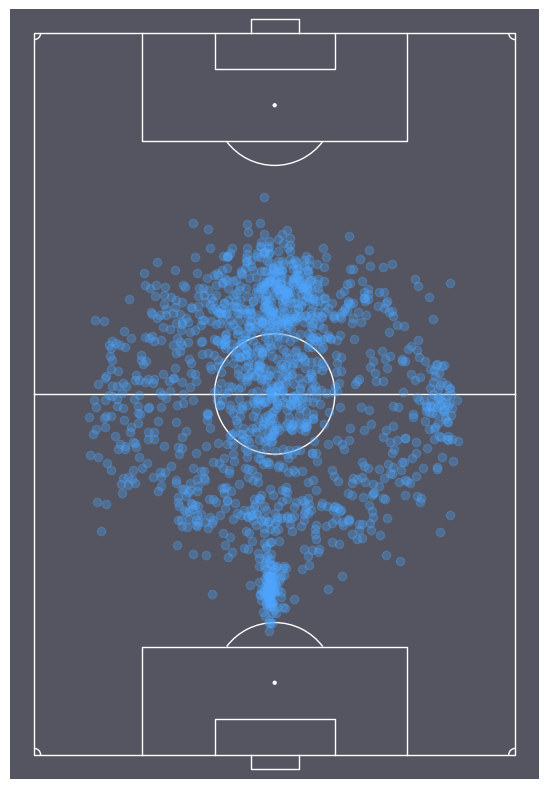

In [674]:
# Plot on a pitch with a heatmap of the scatters 
pitch = VerticalPitch(half=False, goal_type='box', corner_arcs=True, pitch_color='#545560', line_color='white', linewidth=1)
fig, ax = pitch.draw(figsize=(8,8))

# Scatter
pitch.scatter(x_pos, y_pos, ax=ax, color='#4da6ff', alpha=0.3)

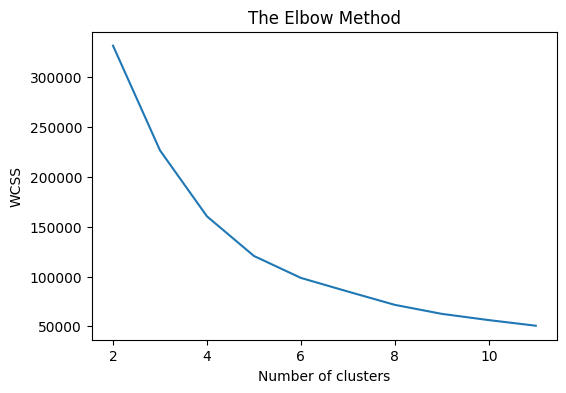

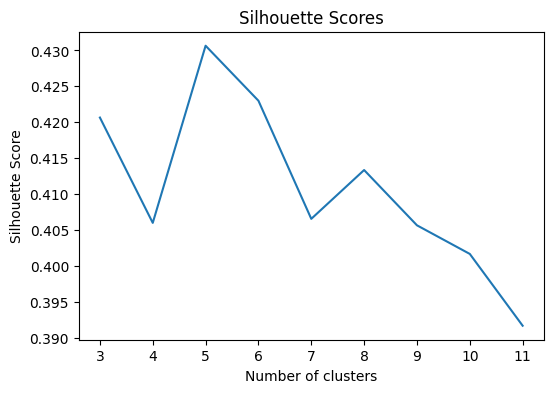

In [681]:
data = list(zip(x_pos, y_pos))

# List to hold the values of WCSS (Within-Cluster Sum of Square)
wcss = []

# List to hold the values of Silhouette Score
sil_scores = []

# Range of possible cluster numbers
cluster_range = range(2, 12)

for i in cluster_range:
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans.fit(data)
    wcss.append(kmeans.inertia_)
    if i > 2:  # Silhouette Score requires at least 2 clusters
        sil_scores.append(silhouette_score(data, kmeans.labels_))

# Plotting the results onto a line graph to observe 'The elbow'
plt.figure(figsize=(6,4))
plt.plot(cluster_range, wcss)
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')  # Within cluster sum of squares
plt.show()

# Plotting the Silhouette Scores
plt.figure(figsize=(6,4))
plt.plot(cluster_range[1:], sil_scores)
plt.title('Silhouette Scores')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.show()

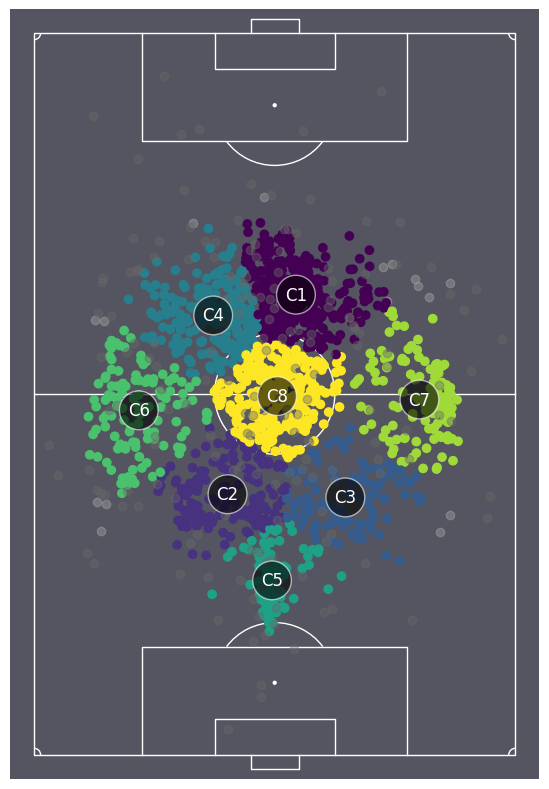

In [676]:
# First, perform KMeans clustering
kmeans = KMeans(n_clusters=CLUSTER_NO)
kmeans.fit(data)

# Get rid of coordinates that are too far away from the centroids
filtered_data = []
filtered_away_data = []
for coord in data:
    if min(np.linalg.norm(np.array([center_x, center_y]) - np.array(coord)) for center_x, center_y in kmeans.cluster_centers_) < 15:
        filtered_data.append(coord)
    else:
        filtered_away_data.append(coord)

# Use the filtered data for KMeans again
kmeans = KMeans(n_clusters=CLUSTER_NO)
kmeans.fit(filtered_data)

# Assuming filtered_data is a list of tuples [(x1, y1), (x2, y2), ...]
x, y = zip(*filtered_data)

# Get cluster labels
labels = kmeans.labels_

# Get cluster centers
centers = kmeans.cluster_centers_
cx, cy = zip(*centers)

pitch = VerticalPitch(half=False, goal_type='box', corner_arcs=True, pitch_color='#545560', line_color='white', linewidth=1)
fig, ax = pitch.draw(figsize=(8,8))

# Scatter the filtered away data as gray dots
x_away, y_away = zip(*filtered_away_data)
pitch.scatter(x_away, y_away, ax=ax, color='darkgrey', alpha=0.4)

# Scatter the filtered data with color labels
pitch.scatter(x, y, c=labels, ax=ax, cmap='viridis')

# Scatter the players that havnt played as much
pitch.scatter(x_pos2, y_pos2, ax=ax, color='dimgray', alpha=0.4)

for i, (center_x, center_y) in enumerate(centers):
    pitch.annotate(f'C{i+1}', (center_x, center_y), color='white', fontsize=12, ha='center', va='center', 
                   bbox=dict(facecolor='black', edgecolor='white', boxstyle='circle', pad=0.5, alpha=0.6), ax=ax)

/var/folders/yn/w3h701111q199y7qdtvn61940000gn/T/ipykernel_93191/1823719535.py:8: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('viridis', CLUSTER_NO)


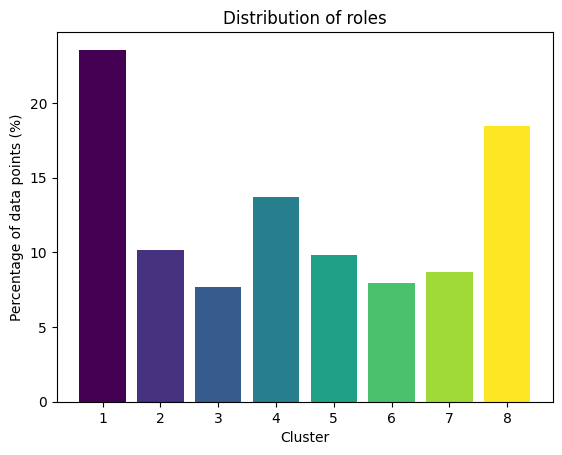

In [677]:
# Count the number of data points in each cluster
counts = np.bincount(labels)

# Calculate the percentage of data points in each cluster
percentages = counts / len(labels) * 100

# Create a color map
cmap = plt.cm.get_cmap('viridis', CLUSTER_NO)

# Create a bar plot of the percentages
plt.bar(range(1, CLUSTER_NO+1), percentages, color=cmap(range(8)))
plt.xlabel('Cluster')
plt.ylabel('Percentage of data points (%)')
plt.title('Distribution of roles')
plt.show()

In [678]:
# For each the coordinates that corresponds to the players in the original df, add the cluster label
df['cluster'] = kmeans.predict(data)

# Map the cluster labels from 0-7 to C1-C8
df['cluster'] = 'C' + (df['cluster'] + 1).astype(str)

# sort by cluster, then by name count
df = df.sort_values(by=['cluster', 'name_count'], ascending=[True, False])

# Print out 10 players that are in every cluster
for i in range(1, CLUSTER_NO+1):
    print(f'Cluster {i}:')
    print(df[df['cluster'] == f'C{i}'].head(5))
    print('\n')

Cluster 1:
              player       xpos       ypos  name_count cluster
110     C. Markstedt  82.564054  35.236379       13854      C1
523       O. Schough  80.742323  53.020734       13794      C1
696        N. Besara  72.341002  40.021856       13031      C1
29   A. Christiansen  71.856960  37.962199       12349      C1
448        M. Janogy  83.484050  37.124142       11743      C1


Cluster 2:
             player       xpos       ypos  name_count cluster
169     E. Karlsson  44.025358  41.267002       15695      C2
910   T. Björkström  44.780751  27.260180       15128      C2
631       M. Fenger  43.937626  41.635590       13262      C2
590      L. Nielsen  44.592693  31.828946       12810      C2
178  E. Lennartsson  44.974697  34.073227       12449      C2


Cluster 3:
              player       xpos       ypos  name_count cluster
653      M. Mathisen  50.109143  46.227747       14077      C3
23      A. Blomqvist  47.149577  44.478068       11098      C3
473          M. Plan  39

/var/folders/yn/w3h701111q199y7qdtvn61940000gn/T/ipykernel_93191/2041827712.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['cluster'] = kmeans.predict(data)
/var/folders/yn/w3h701111q199y7qdtvn61940000gn/T/ipykernel_93191/2041827712.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['cluster'] = 'C' + (df['cluster'] + 1).astype(str)
